# Feature Engineering Compendium

This notebook contains notes and examples of some of the different feature engineering methods that I encounter in my free time. Essentially, this is a space for me to keep them for future use, as well as try them in practice. This practice also helps me remember the methods and understand them better. Hope you learn something from this as well!

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

## Feature Selection
This section contains some of the methods which help pick features and understand their importance in predicting the target variable.

### Mutual Information
Mutual information (MI) is a great general-purpose metric and is especially useful at the start when you might not know what model you would like to use. MI between two quantities measures the extent to which knowledge about one quantity reduces uncertainity about the other. Uncertainty is measured using a quantity from information theory known as 'entropy'. The entropy of a variable roughly means: "how many yes or no questions you would need to describe an occurrence of that variable, on average". The more questions you have to ask, the more uncertain you are about the variable. Mutual information is how many questions you expect the feature to answer about the target. Least possible score is 0.0. In theory, there is no limit; in practice, it is rare to get a value about 2.0. MI is logarithmic, so its rate of increase is slow. 

| Pros | Cons |
| ---- | ---- |
| Easy to use and interpret | Univariate (can't detect interactions between features) |
| Computationally efficient | Actual usefulnes still depends on the model. May need to transform a feature, as a result |
| Theoretically well-founded | |
| Resistant to overfitting | |
| Can detect any kind of relationship | |

Scikit-learn's implementation of MI treats discrete and continous variables differently. So, when using their implementation, make sure to specify which variables are discrete. This is done by passing a list argument in the `discrete` parameter of the function.

Source: [Kaggle](https://www.kaggle.com/ryanholbrook/mutual-information)

In [3]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [5]:
water_df = pd.read_csv("datasets/water_quality.csv")
water_df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [7]:
X = water_df.copy()
y = X.pop("is_safe")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
baseline_model = XGBClassifier()
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_accuracy

[12:00:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.97

In [10]:
mi_scores = mutual_info_classif(X, y, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Score", index=X.columns)
mi_scores.sort_values(ascending=True, inplace=True)

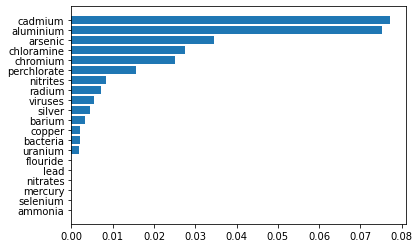

In [11]:
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.show()

<AxesSubplot:xlabel='is_safe', ylabel='cadmium'>

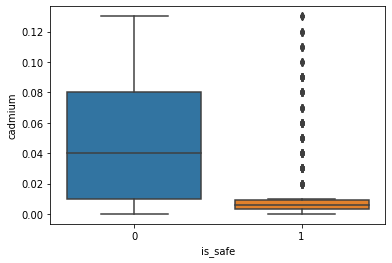

In [61]:
sns.boxplot(x="is_safe", y="cadmium", data=water_df)

<AxesSubplot:xlabel='is_safe', ylabel='ammonia'>

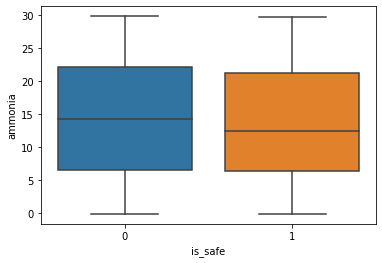

In [79]:
sns.boxplot(x="is_safe", y="ammonia", data=water_df)

Note that ammonia may still be an interaction variable (valuable in combination with another variable), so it is good to investigate this during actual analysis. This may also be the case for all of the other variables.

In [19]:
new_features = mi_scores[mi_scores > 0].index.values.tolist()
X_train_1 = X_train[new_features]
X_test_1 = X_test[new_features]

In [20]:
new_model = XGBClassifier()
new_model.fit(X_train_1, y_train)
new_predictions = new_model.predict(X_test_1)
new_accuracy = accuracy_score(y_test, new_predictions)
new_accuracy

[12:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.95375

The performance worsened, shows that there is interaction within the variables that we got rid of.

If the target variable is continious, use `mutual_info_regression`

### Chi-Square Test
The Chi-Square Test is a statistical test which is used to test the independence of two events/variables. In feature selection, the test is only used with categorical targets. Like other statistical tests, we establish a null hypothesis and an alternative hypothesis. The higher is the Chi-Square value, the higher is the dependence of a variable on another variable. Another important value we get with the test is the p-value. Similarly to other statistical tests, it suggests how statistically significant the results are. 

There are two ways of feature selection using this method. The first method is selecting the top n features with the highest Chi-Square value. This method works best if you know how many features you would like to have in your model. Another method is to use the resulting p-values in order to determine whether the column is statistically significant or not. As usual, pick an alpha value and compare it to the p-value.

| Pros | Cons |
| ---- | ---- |
| Relatively easy to use | Only works on categorical target variables|
| Two easy methods for feature selection | Gets complicated with highly cardinal categorical features | 
| Theoretically well-founded | In case of categorical features, need to make sure each category has more than 5 values |
| Makes no assumptions about the distribution of the data | | 


Sources: [Medium](https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43)

In [2]:
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [4]:
loans = pd.read_csv("datasets/loan_data_set.csv", index_col=0)
loans.dropna(inplace=True)
loans.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [10]:
X = loans.copy()
y = X.pop("Loan_Status")
X["Gender"] = (X["Gender"] == "Male").astype(int)
X["Married"] = (X["Married"] == "Yes").astype(int)
y = (y == "Y").astype(int)
X.drop(["Education", "Self_Employed", "Property_Area", "Dependents"], axis=1, inplace=True)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
baseline_model = XGBClassifier()
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_predictions)
baseline_accuracy

[19:23:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7083333333333334

In [35]:
chi2_values, p_values = chi2(X_train, y_train)

In [36]:
chi2_series = pd.Series(chi2_values, index=X.columns)
chi2_series.sort_values(ascending=False)

CoapplicantIncome    11874.263112
ApplicantIncome        278.106943
LoanAmount              25.039383
Credit_History          16.256902
Loan_Amount_Term         4.663135
Married                  2.748794
Gender                   0.337003
dtype: float64

In [37]:
p_series = pd.Series(p_values, index=X.columns)
p_series

Gender               5.615645e-01
Married              9.732780e-02
ApplicantIncome      1.941471e-62
CoapplicantIncome    0.000000e+00
LoanAmount           5.617121e-07
Loan_Amount_Term     3.081688e-02
Credit_History       5.530775e-05
dtype: float64

Using p-values in order to determine which columns to use:

In [61]:
ALPHA = 0.05
new_features = p_series[p_series < ALPHA].index.values.tolist()
X_train_1 = X_train[new_features]
X_test_1 = X_test[new_features]

In [62]:
new_features

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [43]:
model_1 = XGBClassifier()
model_1.fit(X_train_1, y_train)
new_predictions = model_1.predict(X_test_1)
new_accuracy = accuracy_score(y_test, new_predictions)
new_accuracy

[19:26:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.71875

Yay, an improvement!

In case you are using the first method for chi-square feature selection (top n features), it is more convinient to use sklearn's built in method `SelectKBest` in the `feature_selection` module.

In [47]:
from sklearn.feature_selection import SelectKBest

In [49]:
chi2_selector = SelectKBest(chi2, k=3)
X_2 = chi2_selector.fit_transform(X, y)

In [53]:
new_features = X.columns[chi2_selector.get_support()]  # chi2_selectkr.get_support() gets a mask for the columns/features used
X_train_2 = X_train[new_features]
X_test_2 = X_test[new_features]

In [54]:
model_2 = XGBClassifier()
model_2.fit(X_train_2, y_train)
new_predictions = model_2.predict(X_test_2)
new_accuracy = accuracy_score(y_test, new_predictions)
new_accuracy

[19:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5520833333333334

Despite using top 3 features, the accuracy greatly decreased. Perhaps it is worth increasing the amount of features.

In [57]:
chi2_selector = SelectKBest(chi2, k=4)
X_3 = chi2_selector.fit_transform(X, y)

In [58]:
new_features = X.columns[chi2_selector.get_support()]  # chi2_selectkr.get_support() gets a mask for the columns/features used
X_train_3 = X_train[new_features]
X_test_3 = X_test[new_features]

In [59]:
model_3 = XGBClassifier()
model_3.fit(X_train_3, y_train)
new_predictions = model_3.predict(X_test_3)
new_accuracy = accuracy_score(y_test, new_predictions)
new_accuracy

[19:46:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6979166666666666

In [60]:
new_features

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History'], dtype='object')

The performance increased drastically, but we still obtained a better result when we used the p-value method. I think when the amount of features is small, it makes more sense to use the p-value method; however, if there are thousands of features, it is better to instead use the SelectKBest method, because that will narrow down the amount of features, which will save time when training and testing the model.

## Feature Creation

This section contains some techniques used in order to create new features based on old features.

### Principal Component Analysis

Principal Component Analysis (PCA) creates new features by taking existing features and creating linear combinations of them. These new linear combinations are called principal components of the data. There will be as many principal components as there are features in the linear combinations. The weights used for the linear combinations are called loadings. They tell us what variation it expresses through its signs and magnitudes. PCA also tells us the amount of variation in each component. PCA makes this precise through each component's percent of explained variance. But there isn't necessarily a correlation between amount of variance explained and how useful of a feature it is. It is still good to use something like MI. 

There are two ways to use PCA for feature engineering:

1. Use it as a descriptive techniques. Since the component tells you about variation, you could compute the MI scores for the components and see what kind of variation is most predictive of the target. That could give you ideas, which features to multiply, or divide, etc. Could even try clustering on one or more of the high-scoring components. 
2. Use components themselves as features. Can often be more informative than the original features. Especially useful when:
- The features are highly redundant (multicollinear), PCA will partition out the redundancy into one or more near-zero variance components.
- There's a lot of noise in the data. PCA will collect the signals and leave the noise, boosting the signal-to-noise ratio
- There're highly-correlated features, and your ML algorithm doesn't work well with them. PCA transforms correlated features into uncorrelated components, which could be easier for certain alogorithms to work with. 

Best practices:
- Only works with numeric features, like continious quantities or counts
- PCA is sensetive to scale, so it's good practice to standardize the data, unless there's a good reason not to. 
- Remove or constrain outliers, since they can have an undue influence on the results. 

In [14]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [8]:
houses = pd.read_csv("datasets/houses_to_rent_v2.csv")
features = ["area", "rooms", "bathroom", "parking spaces"]
X = (houses[features] - houses[features].mean(axis=0)) / houses[features].std(axis=0)
y = houses["total (R$)"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
baseline_model = XGBRegressor()
baseline_model.fit(X_train, y_train)
predictions = baseline_model.predict(X_test)
baseline_score = mean_absolute_error(predictions, y_test)
baseline_score

2189.371605201211

In [5]:
pca = PCA()

In [6]:
X_pca = pca.fit_transform(X)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
loadings = pd.DataFrame(pca.components_.T,  columns=component_names, index=X.columns)

In [9]:
mi_scores = mutual_info_regression(X_pca, y, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Score", index=X_pca.columns)
mi_scores.sort_values(ascending=True, inplace=True)

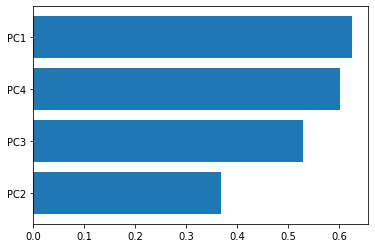

In [10]:
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.show()

In [46]:
X_train_1 = X_train.merge(X_pca, left_index=True, right_index=True)
X_test_1 = X_test.copy()
for pc_col in loadings.columns:
    pc_loadings = loadings[pc_col].values.tolist()
    X_test_1[pc_col] = pc_loadings[0]*X_test_1["area"] + pc_loadings[1]*X_test_1["rooms"] + \
                        pc_loadings[2]*X_test_1["bathroom"] + pc_loadings[3]*X_test_1["parking spaces"]

In [47]:
pca_model = XGBRegressor()
pca_model.fit(X_train_1, y_train)
pca_predictions = pca_model.predict(X_test_1)
pca_score = mean_absolute_error(y_test, pca_predictions)
pca_score

2174.189000397656

Decent improvement! Let's try the second method.

In [43]:
loadings

,PC1,PC2,PC3,PC4
area,0.237441,0.971005,-0.000088,-0.027782
rooms,0.556211,-0.150820,0.630800,-0.519591
bathroom,0.579726,-0.118933,0.117294,0.797505
parking spaces,0.546048,-0.142332,-0.767029,-0.305351


In [49]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
X_train_2["rooms_parking_spaces_interaction"] = X_train_2["rooms"] / X_train_2["parking spaces"]
X_train_2["rooms_bathroom_interaction"] = X_train_2["rooms"] / X_train_2["bathroom"]
X_test_2["rooms_parking_spaces_interaction"] = X_test_2["rooms"] / X_test_2["parking spaces"]
X_test_2["rooms_bathroom_interaction"] = X_test_2["rooms"] / X_test_2["bathroom"]

In [50]:
interaction_model = XGBRegressor()
interaction_model.fit(X_train_2, y_train)
interaction_predictions = interaction_model.predict(X_test_2)
interaction_score = mean_absolute_error(y_test, interaction_predictions)
interaction_score

2210.1870969225724

Performance worsened by a decent amount. But this doesn't indicate that this isn't a good idea. Perhaps, this is the case for this specific dataset, or my application of the method was wrong. Need to look more into this.